# Markov State Models
Markov state Models (MSMs) are kinetic models that describe the conformational dynamics of proteins in terms of jumps between the conformational states of the protein. 
A MSMs can be thought as a map of the conformational space a molecule explores and it consists of 

(1) a set of conformational states which are corresponding to the local minima in the free energy landscape

(2) a transition probability matrix which stands for the rate for transitioning across the barrier separating two states.

Recently, MSMs have had success at modeling long-time statistical dynamics.

## building a MSMs

trajectories -①-> microstates -②-> macrostates -③-> validating

1. microstate clustering
2. macrostate lumping
3. validating the MSM

![MSMs flow](./pics/msm_flow.png)

## generalized ensemble data

In [9]:
# load simulation data
import mdtraj as md

trajs = [md.load('bound_trajs/liganded_1.pdb'), md.load('bound_trajs/liganded_2.pdb'), 
         md.load('bound_trajs/liganded_3.pdb'), md.load('bound_trajs/liganded_4.pdb'), 
         md.load('bound_trajs/liganded_5.pdb'), md.load('bound_trajs/liganded_6.pdb'), 
         md.load('bound_trajs/liganded_7.pdb'), md.load('bound_trajs/liganded_8.pdb'), 
         md.load('bound_trajs/liganded_9.pdb'), md.load('bound_trajs/liganded_10.pdb'), 
         md.load('bound_trajs/liganded_11.pdb'), md.load('bound_trajs/liganded_12.pdb'), 
         md.load('bound_trajs/liganded_13.pdb')] 
top = trajs[0].topology
ref = md.load('bound_trajs/bound.pdb')

In [10]:
trajs

[<mdtraj.Trajectory with 101 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9bf7f2e2d0>,
 <mdtraj.Trajectory with 101 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9c1ed1f5d0>,
 <mdtraj.Trajectory with 101 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9c3c164c50>,
 <mdtraj.Trajectory with 101 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9bec2d05d0>,
 <mdtraj.Trajectory with 101 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9c3ea30490>,
 <mdtraj.Trajectory with 101 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9c1d9cd550>,
 <mdtraj.Trajectory with 101 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9bf860ef50>,
 <mdtraj.Trajectory with 101 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9c1db21350>,
 <mdtraj.Trajectory with 101 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9c1e110f90>,
 <mdtraj.Trajectory with 101 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9c3ea23090>,
 <mdtraj.Trajectory with 101 f

In [11]:
ref

<mdtraj.Trajectory with 1 frames, 4000 atoms, 401 residues, and unitcells at 0x7f9beb40ef10>

## microstate clustering
* clustering microstates based on structural similarity which measured by RMSD for some subset of the atoms.
*  If the partition of the microstates is fine enough, a group of the microstates will correspond/minimize to the same energy-minimum basin.
* RMSD:(1) conformations with very small RMSDs should be able to interconvert rapidly. (2)it is important to see a sufficient number of transitions between microstates.
* the most meaningful grouping of microstates would be to group every conformation in the same trajectory together.
* measure the average RMSD between every pair of temporally adjacent conformations in each trajectory and to ensure that the diameter of each microstate is no more than this value.
* all-heavy-atom 2-2.5 A.

### kinetically-relevant geometric clustering
* a clustering that only groups conformations together if the system can transition between them quickly relative to transitions between clusters.
* two conformations with a 5 Å RMSD could (1) fall within the same free energy basin if they only differ by pivoting of a hinge motion while (2) another pair of conformations separated by the same distance could fall in different basins if they differ by strand pairings in a beta sheet.
* in fact, two conformations separated by only a few A are likely to inter-convert rapidly.

### rich & poor simulation data
* rich case: trajectories from the start conformation to the end conformation.
* poor case: partial or periodical trajectories.

In [12]:
# featurize simulation data
from msmbuilder.featurizer import SuperposeFeaturizer

indices = [atom.index for atom in top.atoms if atom.element.symbol in ['C', 'O', 'N']]
featurizer = SuperposeFeaturizer(indices, ref)
sequences = featurizer.transform(trajs)

### Estimating the transition probability matrix
#### transition count matrix C(τ)
The transition count matrix C(τ), which denotes the number of observed transitions from state i at time t to state j at time t + τ, where τ is the lag time of the model.
* transition count matrix should be symmetric because all elementary transitions should be reversible under equilibrium condition. But the equilibrium sampling is almost never reached in simulations
* Markovian in physical sense: next conformation is simply a deterministic function of the system's current state.
* lag time or observation interval τ
* the Chapman-Kolmogorov equation: taking n steps with an MSM with a lag
* time of τ should be equivalent to an MSM with a lag time of nτ.

#### transition probability matrix T(τ)
the transition probability matrix T(τ) includes the probability of transitions from state i to state j in
a certain time interval τ is obtained by normalizing C(τ) with the sum of all transitions from state i. 
* To ensure that the total population of all the states is conserved, a maximum likelihood estimate of the transition probability matrix that obeys the detailed balance is obtained. 
* The eigenvalues/eigenvectors of the transition matrix gives information about the aggregate transitions between subsets of states in the model and what timescales these transitions occur on. 
* The equilibrium populations of the individual states are estimated from the first eigenvector of the transition probability matrix. 
* The timescales of the dynamical processes occurring on the conformational landscape of the protein can be obtained by estimating the eigenvalues of this matrix.

In [15]:
from msmbuilder.cluster import KCenters
from msmbuilder.msm import MarkovStateModel

msmts0, msmts1 = {}, {}
lag_times = [1, 10, 20, 30, 40]
n_states = [4, 8, 16, 32, 64]

for n in n_states:
    msmts0[n] = []
    msmts1[n] = []
    for lag_time in lag_times:
        assignments = KCenters(n_clusters=n).fit_predict(sequences)
        msm = MarkovStateModel(lag_time=lag_time, verbose=False).fit(assignments)
        timescales = msm.timescales_
        msmts0[n].append(timescales[0])
        msmts1[n].append(timescales[1])
        print('n_states=%d\tlag_time=%d\ttimescales=%s' % (n, lag_time, timescales[0:2]))
    print()

n_states=4	lag_time=1	timescales=[ 13.69597038   5.36032666]
n_states=4	lag_time=10	timescales=[ 18.52680444  12.1759904 ]
n_states=4	lag_time=20	timescales=[ 114.84345412   26.78377022]
n_states=4	lag_time=30	timescales=[ 218.41948697   36.78146018]
n_states=4	lag_time=40	timescales=[ 94.22832128  37.264041  ]
()
n_states=8	lag_time=1	timescales=[ 7.53525981  5.72560249]
n_states=8	lag_time=10	timescales=[ 46.48934225  21.01191403]
n_states=8	lag_time=20	timescales=[ 226.51823456   48.10222444]
n_states=8	lag_time=30	timescales=[ 305.6275493   39.7581925]
n_states=8	lag_time=40	timescales=[ 144.40534729   52.57632782]
()
n_states=16	lag_time=1	timescales=[ 12.82118785   9.82623573]
n_states=16	lag_time=10	timescales=[ 66.09281383  40.81237063]
n_states=16	lag_time=20	timescales=[ 280.91344753   58.10146719]
n_states=16	lag_time=30	timescales=[ 104.13862542   61.24680165]
n_states=16	lag_time=40	timescales=[ 401.44046677  102.43904196]
()
n_states=32	lag_time=1	timescales=[ 44.5413152 

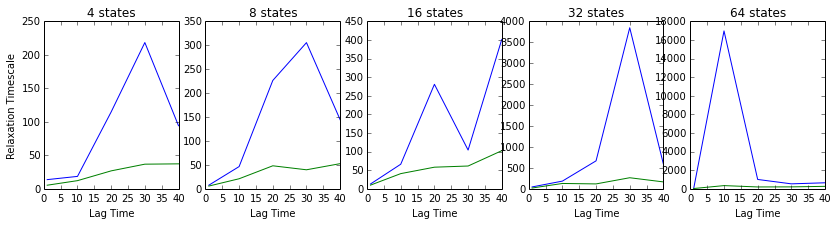

In [16]:
%matplotlib inline
from matplotlib.pyplot import *

figure(figsize=(14,3))

for i, n in enumerate(n_states):
    subplot(1,len(n_states),1+i)
    plot(lag_times, msmts0[n])
    plot(lag_times, msmts1[n])
    if i == 0:
        ylabel('Relaxation Timescale')
    xlabel('Lag Time')
    title('%d states' % n)

show()

## macrostate lumping
looking at the transition/kinetics between the microstates in order to connect those microstates separated by low-energy barriers (i.e. those with fast inter-microstates transitions) into a single metastable state (macrostate). In this way, by first partitioning the conformations into microstates and then lumping the microstates into macrostates the complete energy landscape can be partitioned into a small set of metastable states, such macrostate division of the energy landscape is not only representing the underlying kinetics of the system, but also by reducing the number of states in the system.

* macrostates are coarse-graining microstate models.
* kinetically-relevant states require that structures within a state can inter-convert on timescales faster than the lag time. 
* increasing the lag time means that states can get larger and more coarse grained.

###  eigenvector 
eigenvector actually corresponds to a certain state distribution that can give rise to a sustainable mode of transitions between groups of states, with the signed structure of the eigenvector indicating the two groups between which the transition occurs.


### Perron cluster cluster analysis (PCCA)

## Adaptive sampling
In the adaptive sampling scheme, MSMs are built after an initial dataset is obtained to identify new conformational states of protein, which are then used as the starting points for future simulations.

Adaptive sampling procedures seek to identify the starting configurations for future simulations such that the conformational landscapes can be sampled efficiently.

This procedure ensures that the future simulations are started from the edges of the conformational landscape, thereby avoiding the already well-sampled stable states.

### adaptive seeding method (ASM)
### error analysis technique (EAT)
* determine the main contributors to the error which gives rise to the greatest uncertainties.
* each row corresponds to transitions from a single state, so if we find that one row contributes the most to the uncertainty , we can decrease the uncertainty from that row by generating new transitions from that state.

## Validating the MSMs
Testing whether an MSM is self-consistent.
### Swope–Pitera eigenvalue test
### Chapman–Kolmogorov test
### Bayesian model selection approaches.

## MSM requirements
1. states are metastable.
2. intrastate transitions are fast.
3. interstate transitions are distinct and slow.

![MSMs](./pics/msm.png)
 (a). Projection of the energy potential
for 100 microstates onto one discrete coordinate, three energy bins were identified. (b). Transition matrix T for the 100 microstates. (c). Left eigenvectors of T indicating the transition information between different microstates. Each eigenvector corresponds to a certain mode of sustainable transitions between groups of states with the signed structure indicating the two groups. Except the first eigenvector provides the stationary distribution. (d). The eigenvalue spectrum of T. (e) Projections of the 100 microstates onto the second and third right eigenvectors of T. (f) Transition information for the macrostates A, B and C.

## future work
1. state scalable MSMs.
2. extendible clustering method and training data.